In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{siunitx}\sisetup{detect-all}\usepackage{sansmath}\sansmath')
params = {
    'legend.fontsize': 9,
    'axes.labelsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
}
plt.rcParams.update(params)

In [3]:
# Data locations
psm_dir = Path('../simulations/outputnops512_dm8')

In [4]:
bin_size = 33

In [5]:
ell = np.arange(1536)
ell_binned = ell[2:1520].reshape(-1, bin_size).mean(axis=1)

## Simulation map from test set

In [6]:
quadratic_fit = np.loadtxt('spectra-bias-quadratic-fit.txt')
fits_cl = astropy.io.fits.open(psm_dir / 'sim0999/cmb_lensed_cl.fits')
ref_cl = np.loadtxt('sim-ref-cl.txt')
ann_cl = np.loadtxt('sim-ann-cl.txt') * np.poly1d(quadratic_fit)(np.arange(ref_cl.shape[0]))

In [7]:
sim_ann_dl_diff = (ann_cl * 1e12 - fits_cl[1].data[0][3][:1536]) * ell * (ell + 1) / (2 * np.pi)
sim_ref_dl_diff = (ref_cl * 1e12 - fits_cl[1].data[0][3][:1536]) * ell * (ell + 1) / (2 * np.pi)

In [8]:
sim_ref_dl_diff_binned_mean = sim_ref_dl_diff[2:1520].reshape(-1, bin_size).mean(axis=1)
sim_ref_dl_diff_binned_std = sim_ref_dl_diff[2:1520].reshape(-1, bin_size).std(axis=1) / np.sqrt(bin_size)
sim_ann_dl_diff_binned_mean = sim_ann_dl_diff[2:1520].reshape(-1, bin_size).mean(axis=1)
sim_ann_dl_diff_binned_std = sim_ann_dl_diff[2:1520].reshape(-1, bin_size).std(axis=1) / np.sqrt(bin_size)

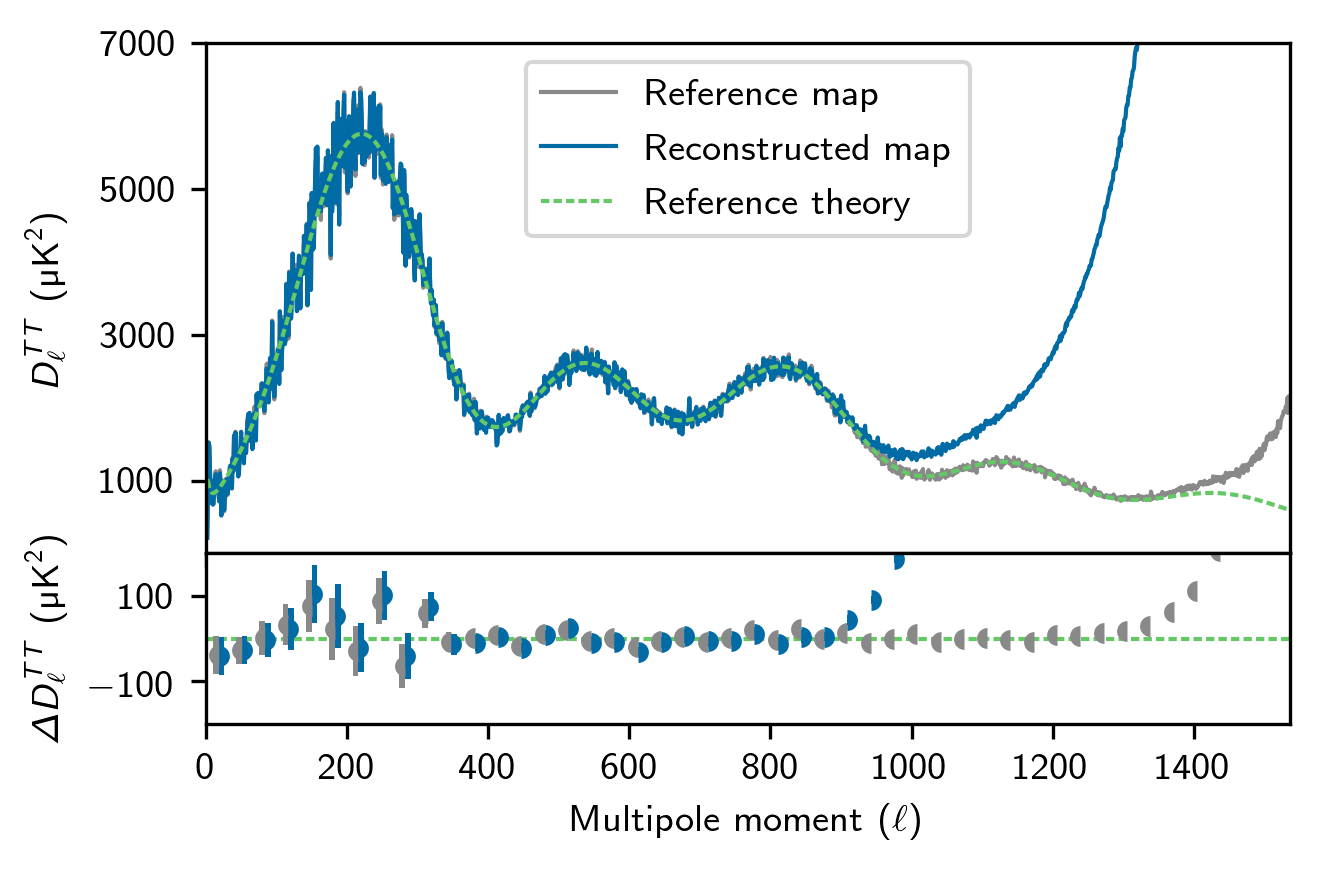

In [9]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4.5, 3.0), dpi=150, gridspec_kw={'height_ratios': [3, 1]})

axs[0].plot(ell[2:], (ref_cl * ell * (ell + 1) * 1e12 / (2 * np.pi))[2:], label='Reference map', lw=1, c='#898989')
axs[0].plot(ell[2:], (ann_cl * ell * (ell + 1) * 1e12 / (2 * np.pi))[2:], label='Reconstructed map', lw=1, c='#006ba4')
axs[0].plot(fits_cl[1].data[0][2][2:1536], (fits_cl[1].data[0][3][:1536] * ell * (ell + 1) / (2 * np.pi))[2:], label='Reference theory', lw=1, c='#64c864', ls=(0, (2, 1)))

axs[0].set_xlim((0, 1536))
axs[0].set_ylim((0, 7000))
axs[0].set_yticks([1000, 3000, 5000, 7000])
axs[0].set_ylabel('$D_\ell^{TT}$ (\si{\micro\kelvin\squared})')
axs[0].legend()

axs[1].axhline(c='#64c864', zorder=0, ls=(0, (2, 1)), lw=1)

# Only fill half of marker
axs[1].plot(ell_binned, sim_ref_dl_diff_binned_mean, ls='', marker='o', ms=5, fillstyle='left', mec='none', c='#898989')
axs[1].plot(ell_binned, sim_ann_dl_diff_binned_mean, ls='', marker='o', ms=5, fillstyle='right', mec='none', c='#006ba4')
# Use fill between to plot touching error bars
xwhere = np.vstack((np.ones(ell.size // bin_size), np.ones(ell.size // bin_size), np.zeros(ell.size // bin_size))).reshape((-1,), order='F').astype(np.bool)
xcoords = np.vstack((ell_binned - 8, ell_binned, np.zeros(ell.size // bin_size))).reshape((-1,), order='F')
y0 = np.vstack((sim_ref_dl_diff_binned_mean - sim_ref_dl_diff_binned_std, sim_ref_dl_diff_binned_mean - sim_ref_dl_diff_binned_std, np.zeros(ell.size // bin_size))).reshape((-1,), order='F')
y1 = np.vstack((sim_ref_dl_diff_binned_mean + sim_ref_dl_diff_binned_std, sim_ref_dl_diff_binned_mean + sim_ref_dl_diff_binned_std, np.zeros(ell.size // bin_size))).reshape((-1,), order='F')
axs[1].fill_between(xcoords, y0, y1, xwhere, color='#898989', ls='None', lw=0)
xcoords = np.vstack((ell_binned, ell_binned + 8, np.zeros(ell.size // bin_size))).reshape((-1,), order='F')
y0 = np.vstack((sim_ann_dl_diff_binned_mean - sim_ann_dl_diff_binned_std, sim_ann_dl_diff_binned_mean - sim_ann_dl_diff_binned_std, np.zeros(ell.size // bin_size))).reshape((-1,), order='F')
y1 = np.vstack((sim_ann_dl_diff_binned_mean + sim_ann_dl_diff_binned_std, sim_ann_dl_diff_binned_mean + sim_ann_dl_diff_binned_std, np.zeros(ell.size // bin_size))).reshape((-1,), order='F')
axs[1].fill_between(xcoords, y0, y1, xwhere, color='#006ba4', ls='None', lw=0)

axs[1].set_ylim((-200, 200))
axs[1].set_yticks([-100, 100])
axs[1].set_xlabel('Multipole moment ($\ell$)')
axs[1].set_ylabel('$\Delta D_\ell^{TT}$ (\si{\micro\kelvin\squared})')

fig.align_ylabels()
fig.tight_layout()
fig.subplots_adjust(hspace=0)  # Needs to be after tight_layout

plt.savefig('spectra-test.pdf')

## Evaluation using Planck maps

In [10]:
planck_dls = np.loadtxt('/data/planck/COM_PowerSpect_CMB-TT-full_R3.01.txt', skiprows=1, unpack=True)
planck_ann_cl = np.loadtxt('planck-ann-cl.txt')
planck_ann_dl = planck_ann_cl * ell * (ell + 1) * 1e12 / (2 * np.pi) * np.poly1d(quadratic_fit)(np.arange(planck_ann_cl.shape[0]))
planck_theory_dls = np.loadtxt('/data/planck/COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt', skiprows=1, unpack=True)

In [11]:
planck_ref_dl_diff = planck_dls[1][:1536] - planck_theory_dls[1][:1536]
planck_ann_dl_diff = planck_ann_dl - planck_theory_dls[1][:1536]

In [12]:
planck_ref_dl_diff_binned_mean = planck_ref_dl_diff[2:1520].reshape(-1, bin_size).mean(axis=1)
planck_ref_dl_diff_binned_std = planck_ref_dl_diff[2:1520].reshape(-1, bin_size).std(axis=1) / np.sqrt(bin_size)
planck_ann_dl_diff_binned_mean = planck_ann_dl_diff[2:1520].reshape(-1, bin_size).mean(axis=1)
planck_ann_dl_diff_binned_std = planck_ann_dl_diff[2:1520].reshape(-1, bin_size).std(axis=1) / np.sqrt(bin_size)

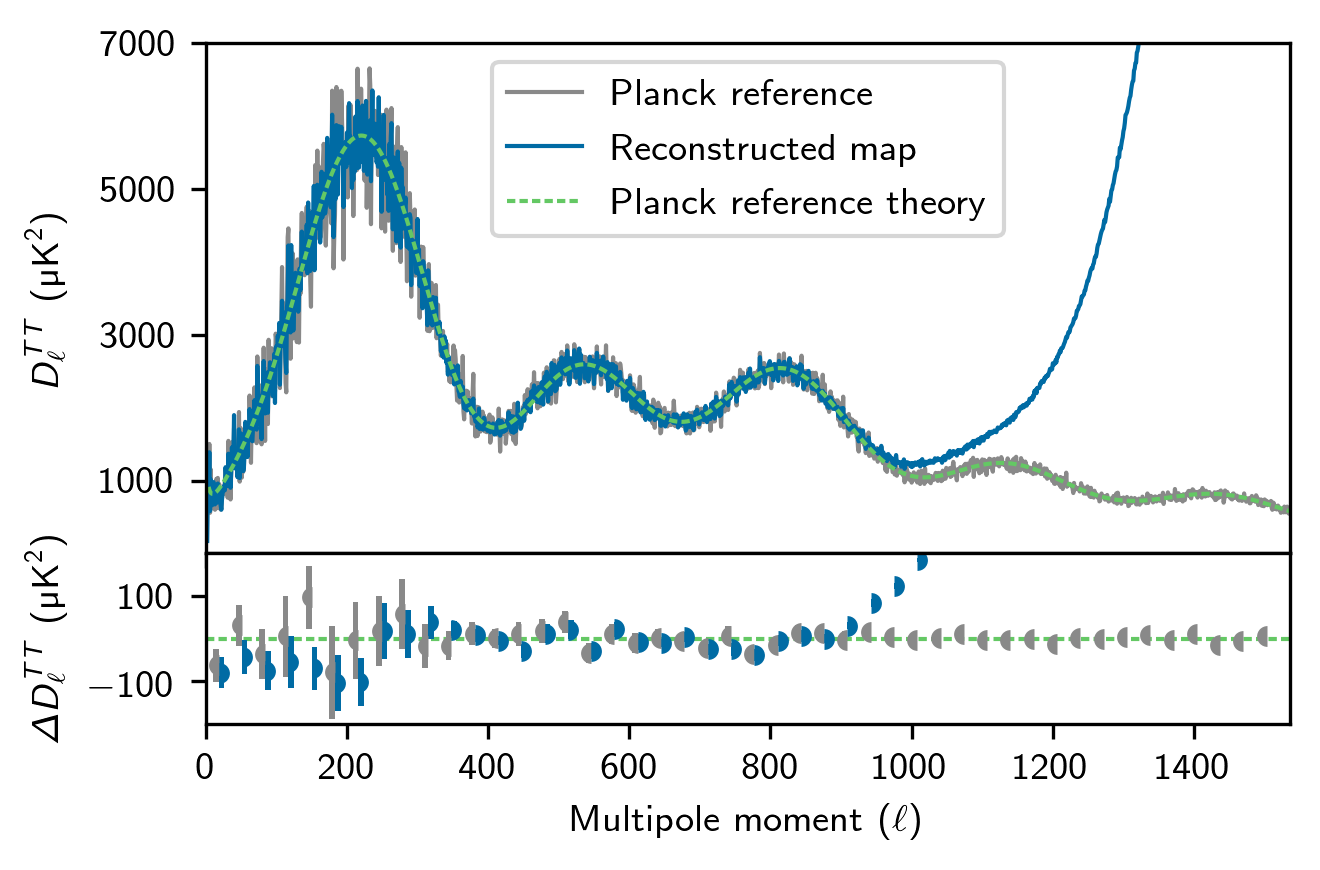

In [13]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4.5, 3.0), dpi=150, gridspec_kw={'height_ratios': [3, 1]})

axs[0].plot(planck_dls[0][2:], planck_dls[1][2:], label='Planck reference', lw=1, c='#898989')
axs[0].plot(ell[2:], planck_ann_dl[2:], label='Reconstructed map', lw=1, c='#006ba4')
axs[0].plot(planck_theory_dls[0][2:], planck_theory_dls[1][2:], label='Planck reference theory', lw=1, c='#64c864', ls=(0, (2, 1)))

axs[0].set_xlim((0, 1536))
axs[0].set_ylim((0, 7000))
axs[0].set_yticks([1000, 3000, 5000, 7000])
axs[0].set_ylabel('$D_\ell^{TT}$ (\si{\micro\kelvin\squared})')
axs[0].legend()

axs[1].axhline(c='#64c864', zorder=0, ls=(0, (2, 1)), lw=1)

# Only fill half of marker
axs[1].plot(ell_binned, planck_ref_dl_diff_binned_mean, ls='', marker='o', ms=5, fillstyle='left', mec='none', c='#898989')
axs[1].plot(ell_binned, planck_ann_dl_diff_binned_mean, ls='', marker='o', ms=5, fillstyle='right', mec='none', c='#006ba4')
# Use fill between to plot touching error bars
xwhere = np.vstack((np.ones(ell.size // bin_size), np.ones(ell.size // bin_size), np.zeros(ell.size // bin_size))).reshape((-1,), order='F').astype(np.bool)
xcoords = np.vstack((ell_binned - 8, ell_binned, np.zeros(ell.size // bin_size))).reshape((-1,), order='F')
y0 = np.vstack((planck_ref_dl_diff_binned_mean - planck_ref_dl_diff_binned_std, planck_ref_dl_diff_binned_mean - planck_ref_dl_diff_binned_std, np.zeros(ell.size // bin_size))).reshape((-1,), order='F')
y1 = np.vstack((planck_ref_dl_diff_binned_mean + planck_ref_dl_diff_binned_std, planck_ref_dl_diff_binned_mean + planck_ref_dl_diff_binned_std, np.zeros(ell.size // bin_size))).reshape((-1,), order='F')
axs[1].fill_between(xcoords, y0, y1, xwhere, color='#898989', ls='None', lw=0)
xcoords = np.vstack((ell_binned, ell_binned + 8, np.zeros(ell.size // bin_size))).reshape((-1,), order='F')
y0 = np.vstack((planck_ann_dl_diff_binned_mean - planck_ann_dl_diff_binned_std, planck_ann_dl_diff_binned_mean - planck_ann_dl_diff_binned_std, np.zeros(ell.size // bin_size))).reshape((-1,), order='F')
y1 = np.vstack((planck_ann_dl_diff_binned_mean + planck_ann_dl_diff_binned_std, planck_ann_dl_diff_binned_mean + planck_ann_dl_diff_binned_std, np.zeros(ell.size // bin_size))).reshape((-1,), order='F')
axs[1].fill_between(xcoords, y0, y1, xwhere, color='#006ba4', ls='None', lw=0)

axs[1].set_ylim((-200, 200))
axs[1].set_yticks([-100, 100])
axs[1].set_xlabel('Multipole moment ($\ell$)')
axs[1].set_ylabel('$\Delta D_\ell^{TT}$ (\si{\micro\kelvin\squared})')

fig.align_ylabels()
fig.tight_layout()
fig.subplots_adjust(hspace=0)  # Needs to be after tight_layout

plt.savefig('spectra-planck.pdf')